# **Train Models**
The aim of this notebook is to take our prepared data and use it to train some models.

## - **Imports**

In [3]:
import numpy as np
import pandas as pd
from math import sqrt
import os

import xgboost as xgb
from xgboost import DMatrix

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


In [4]:

# Change to the parent directory to include other libraries.
os.chdir("..")

from scripts import prepare_data

## - **Load the Data**

In [5]:
df_base = pd.read_csv("data/raw.csv")
df, y = prepare_data.prepare_data(df_base, save_data=True, use_old=False, price_threshold=(0, 1500000))


def prepare_data
    - Filtering data based on price threshold: (0, 1500000)
    - Initial Size: 112292
    - New Size: 108238

def enrich_data
    - Enriching DataFrame to include more features...
Enriching data...
Adding full_name column for ease of lookup


100%|██████████| 6381/6381 [01:31<00:00, 69.71it/s] 


Found cars: 108238
Not found: 1028
Data enriched. Total Time: 91.7s
Saving data to data/data_enriched.csv
    - Returning dataframe


    - Standardizing data...
    - Extracting make and model from Title...


108238it [00:23, 4548.33it/s]


    - Renaming columns...
All Column Names: Index(['unnamed:_0', 'title', 'variant', 'year', 'price', 'mileage', 'status',
       'transmission', 'rating', 'location', 'engine_capacity',
       'engine_detail', 'cylinder_layout_and_quantity', 'fuel_type',
       'fuel_capacity', 'avg_fuel_consumption', 'max_power', 'acceleration',
       'max_speed', 'co2_emissions', 'max_torque', 'driven_wheels',
       'power_steering', 'stability_control', 'traction_control',
       'front_tyres', 'rear_tyres', 'air_conditioning', 'electric_windows',
       'num_seats', 'heated_seats_front', 'no_of_doors', 'make', 'model'],
      dtype='object')
    - Converting columns to floats...
Tring to convert col: 'fuel_capacity' to float
Tring to convert col: 'acceleration' to float
Tring to convert col: 'max_power' to float
Tring to convert col: 'avg_fuel_consumption' to float
Tring to convert col: 'mileage' to float
Tring to convert col: 'price' to float
Tring to convert col: 'engine_capacity' to float
Tri

100%|██████████| 108238/108238 [00:17<00:00, 6101.48it/s]


Data standardized. Total Time: 42.01s
transmission
make
model
fuel_type
province
no_of_doors
Filling missing values...
Missing values filled. Total time: 0.066s 

Saving data...
Saving complete. Total time: 0.02s

Data Preparation Complete! Total Time = 134.934s



## - **Setting Variables**

In [6]:
n = 0.2     # The split factor for training, validation, and test subsets
SEED = 42   # For random outcomes

objective = "reg:gamma"
eval_metric = "rmse"

# variables from tuning the parameters
best_max_depth = 3
best_subsample = 1.0
best_colsample_bytree = 0.3
best_colsample_bylevel = 0.7
best_colsample_bynode = 0.9
best_min_child_weight = 6

best_lambda = 1.0
best_eta = 0.1

# - **Splitting the Data**

In [7]:
# Combine df and price so we can shuffle the data and split them together
target = "price"

df_combined = df.copy()
df_combined[target] = y

df_full_train, df_test = train_test_split(df_combined, test_size=n, shuffle=True, random_state=SEED)
df_train, df_val = train_test_split(df_full_train, test_size = n/(1-n), shuffle=True, random_state=SEED)


df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_full_train = df_full_train[target].values
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

del df_full_train[target]
del df_train[target]
del df_val[target]
del df_test[target]


df_full_train.shape, df_train.shape, df_val.shape, df_test.shape

((86590, 13), (64942, 13), (21648, 13), (21648, 13))

In [8]:
dm_full = DMatrix(df, label=y, enable_categorical=True)
dm_full_train = DMatrix(df_full_train, label=y_full_train, enable_categorical=True)
dm_train = DMatrix(df_train, label=y_train, enable_categorical=True)
dm_val = DMatrix(df_val, label=y_val, enable_categorical=True)
dm_test = DMatrix(df_test, label=y_test, enable_categorical=True)

## - **Training a model and tuning the parameters**

In [9]:
def parse_output(output: str) -> pd.DataFrame:
    """
    Function to take the output of training an XGBoost model and convert the results to a pandas DataFrame so the results can be easily manipulated and examined.
    
    :param str output: The output.stdout captured from training an XGBoost model. 

    :return pd.DataFrame: DataFrame containing the results from training an XGBoost model.
    """

    scores = []
    res = output.split("\n")

    for line in res:
        items = line.split("\t")
        if len(items) > 1:
            index = int(items[0].strip("[]"))
            train_score = float(items[1].split(":")[1])
            val_score = float(items[2].split(":")[1])
            scores.append([index, train_score, val_score])

    return pd.DataFrame(data=scores, columns=["iteration", "train_rmse", "val_rmse"])

    
def plot_results(res: pd.DataFrame, x_col="iteration", ylim=None, columns=[], ax=None, legend=True) -> None:
    """
    Function creates a matplotlib plot. Parameters specify what to plot.
    
    :param pd.DataFrame res: A pandas DataFrame containing the results to be plotted. Must contain an 'iteration' column used to plot along the x-axis.
    :param list columns: The names of the columns in the res DataFrame to be plotted.
    :param ax: A matplotlib axes object. If None, uses the current axes.
    """
    if ax is None:
        ax = plt.gca()
    
    if columns:
        display_columns = columns
    else:
        display_columns = res.columns

    for col in display_columns:
        if col != x_col:
            ax.plot(res[x_col], res[col], label=col)
    
    ax.set_xlabel(x_col)
    ax.set_ylabel("Score")

    if ylim:
        ax.set_ylim(ylim)

    if legend:
        ax.legend()

def plot_evals(evals: dict, col_name, fig_width=16, fig_height=4) -> None:
    """
        Function to plot the evaluation scores used during tuning model. 
    """

    # Sort the values by key
    evals = {k: v for k, v in sorted(evals.items())}

    df_eval = pd.DataFrame(evals).transpose()
    df_eval[col_name] = df_eval.index

    fig, axes = plt.subplots(1, 5, figsize=(fig_width, fig_height))  # 1 row, 2 columns

    for i, val in enumerate(["Mean Absolute Error", "Mean Absolute Percentage Error", "Mean Squared Error", "Root Mean Squared Error", "R Squared"]):

        plot_results(df_eval, x_col=col_name, columns=[val], ax=axes[i], legend=False)
        axes[i].set_title(val)


    plt.tight_layout()
    plt.show()

    print(find_best_results(evals))


def eval(y_actual, y_pred) -> list:
    """ 
        Function to take a list of actual values and predicted values and provide some key metrics to evaluate performance. 
        Evals to return:
            - RMSE
            - R2
            - MAE
            - Comparison to a baseline
            - Maybe plot residuals
    """

    assert len(y_actual) == len(y_pred)

    n = len(y_actual)

    total = 0
    for y in y_actual:
        total += y
    
    mean = total / n
    
    # RMSE
    tse = 0         # Total Squared Error
    te = 0          # Total Error
    tfe = 0         # Total Fractional Error

    thing = 0
    for i in range(n):
        tse += (y_actual[i] - y_pred[i])**2
        te += abs(y_actual[i] - y_pred[i])

        thing += (y_actual[i] - mean) ** 2

        tfe += abs((y_pred[i]-y_actual[i]) / y_actual[i])

    r2 = float(round(1 - (tse / thing), 4))

    mfe = float(round(tfe / n, 5))


    mse = float(round(tse / n, 3))
    rmse = sqrt(mse)
    mae = float(round(te / n, 3))



    return {
          "Mean Absolute Error"             : mae
        , "Mean Absolute Percentage Error"  : mfe
        , "Mean Squared Error"              : mse
        , "Root Mean Squared Error"         : rmse
        , "R Squared"                       : r2
    }

def find_best_results(evals: dict) -> dict:
    
    best_mae = np.inf
    best_mae_key = None

    best_mape = np.inf
    best_mape_key = None

    best_mse = np.inf
    best_mse_key = None

    best_rmse = np.inf
    best_rmse_key = None

    best_r2 = -np.inf
    best_r2_key = None

    for k, v in evals.items():

        for metric, value in v.items():
            if metric == "Mean Absolute Error" and value < best_mae:
                best_mae = value
                best_mae_key = k
            
            elif metric == "Mean Absolute Percentage Error" and value < best_mape:
                best_mape = value
                best_mape_key = k
            
            elif metric == "Mean Squared Error" and value < best_mse:
                best_mse = value
                best_mse_key = k

            elif metric == "Root Mean Squared Error" and value < best_rmse:
                best_rmse = value
                best_rmse_key = k

            elif metric == "R Squared" and value > best_r2:
                best_r2 = value
                best_r2_key = k
    
    return {
        "Mean Absolute Error"  : {best_mae_key: best_mae}
        , "Mean Absolute Percentage Error"  : {best_mape_key: best_mape}
        , "Mean Squared Error"  : {best_mse_key: best_mse}
        , "Root Mean Squared Error"  : {best_rmse_key: best_rmse}
        , "R Squared"  : {best_r2_key: best_r2}
    }


def calculate_mape(y_actual, y_pred):
    """
    Calculate Mean Absolute Percentage Error
    
    Parameters:
    y_actual: actual values
    y_pred: predicted values
    
    Returns:
    MAPE as a percentage
    """
    mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
    return mape

In [10]:
%%capture output
# First, let's train XGBoost Model

watchlist = [(dm_train, "train"), (dm_val, "val")]

xgb_params = {
    # Standard params
    "objective"     : objective,
}

model = xgb.train(xgb_params, dm_train, num_boost_round=101, evals=watchlist, verbose_eval=5)

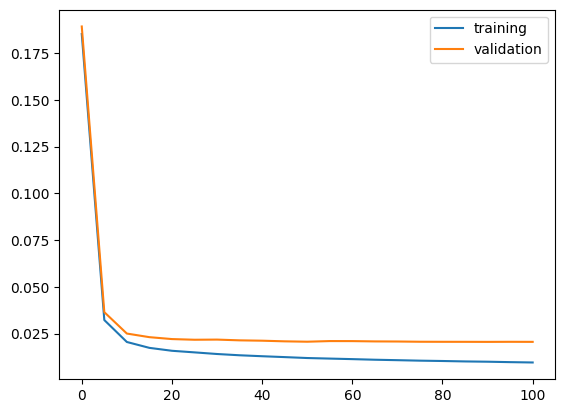

In [11]:
df_results = parse_output(output.stdout)
plt.plot(df_results["iteration"], df_results["train_rmse"], label="training")
plt.plot(df_results["iteration"], df_results["val_rmse"], label="validation")

plt.legend()

In [12]:
base_preds = model.predict(dm_val)

base_performance = eval(y_val, base_preds)
base_performance

{'Mean Absolute Error': 33107.9,
 'Mean Absolute Percentage Error': 0.09033,
 'Mean Squared Error': 3260673319.442,
 'Root Mean Squared Error': 57102.30572789509,
 'R Squared': 0.9536}

### - **Training the `max_depth` hyperparameter**
- Let's start by varying this between 1 and 10, and seeing if we can find a min/max value.

In [13]:
df_max_depth = pd.DataFrame()
evals_max_depth = {}

In [20]:
%%capture output

max_depth = 30

watchlist = [(dm_train, "train"), (dm_val, "val")]
xgb_params = {
    # Standard Parameters
    "objective"     : objective,
    "eval_metric"   : eval_metric,

    # Booster Parameters
    "max_depth"     : max_depth,

    
}

model = xgb.train(xgb_params, dm_train, num_boost_round=801, evals=watchlist, verbose_eval=20)

In [21]:
temp = parse_output(output.stdout)

df_max_depth["iteration"] = temp["iteration"]
df_max_depth[f"max_depth={max_depth}"] = temp["val_rmse"]

preds = model.predict(dm_val)
evals_max_depth[max_depth] = eval(y_val, preds)

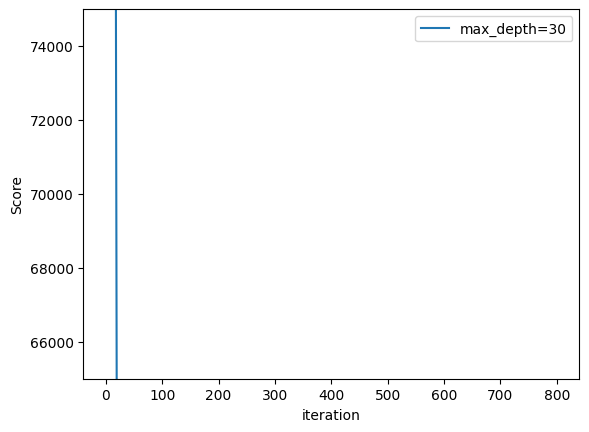

In [22]:
plot_results(df_max_depth, ylim=(65000, 75000))

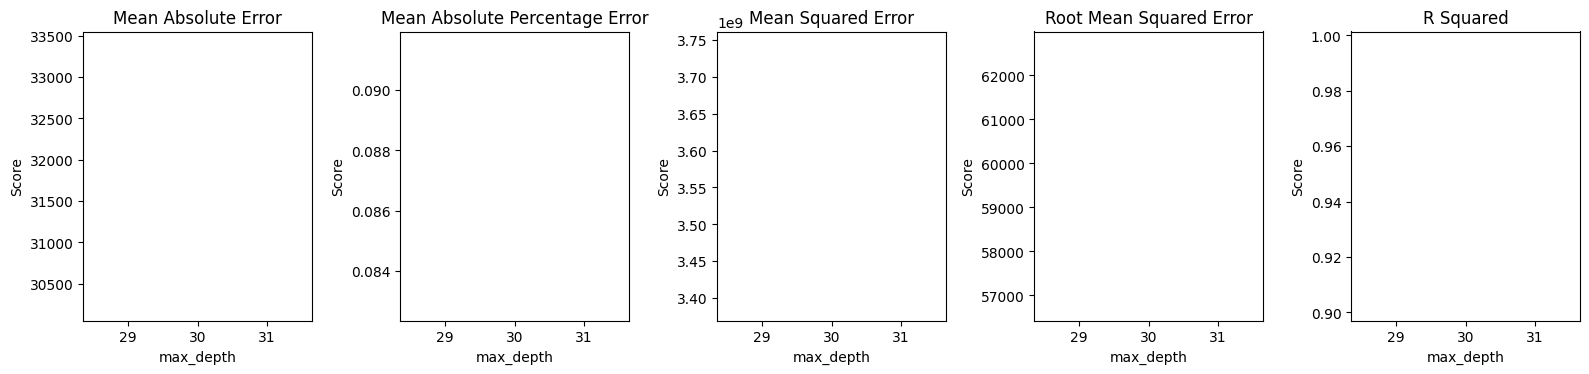

{'Mean Absolute Error': {30: 31801.861}, 'Mean Absolute Percentage Error': {30: 0.08715}, 'Mean Squared Error': {30: 3565400901.822}, 'Root Mean Squared Error': {30: 59710.978067872915}, 'R Squared': {30: 0.9492}}


In [23]:
plot_evals(evals_max_depth, "max_depth")

### - **Next, let's train the `subsample` hyperparameter**
- We'll vary it from 0.1 to 0.9

In [24]:
df_subsample = pd.DataFrame()
evals_subsample = {}

In [25]:
%%capture output

subsample = 1.0

watchlist = [(dm_train, "train"), (dm_val, "val")]
xgb_params = {
    # Standard Parameters
    "objective"     : objective,
    "eval_metric"   : eval_metric,

    # Trained Parameters
    "max_depth"     : best_max_depth,

    # Current Parameter
    "subsample"     : subsample
    
}

model = xgb.train(xgb_params, dm_train, num_boost_round=1001, evals=watchlist, verbose_eval=20)

In [26]:
sumsample_temp = parse_output(output.stdout)

df_subsample["iteration"] = sumsample_temp["iteration"]
df_subsample[f"subsample={subsample}"] = sumsample_temp["val_rmse"]

preds = model.predict(dm_val)
evals_subsample[subsample] = eval(y_val, preds)

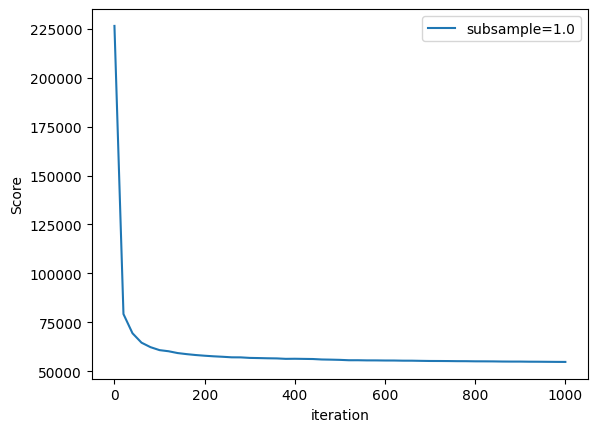

In [27]:
plot_results(df_subsample)

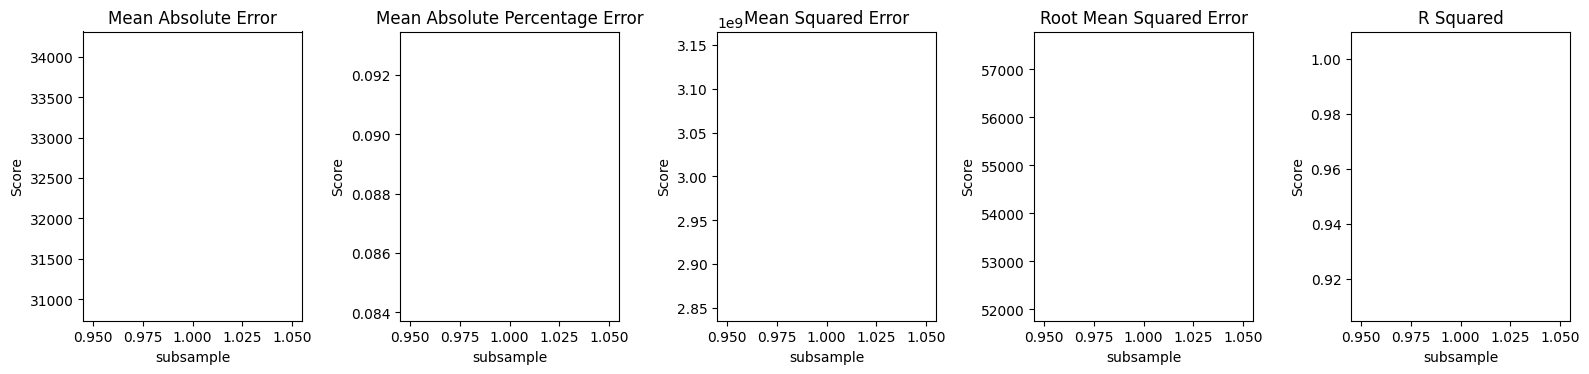

{'Mean Absolute Error': {1.0: 32524.022}, 'Mean Absolute Percentage Error': {1.0: 0.08859}, 'Mean Squared Error': {1.0: 3000333353.778}, 'Root Mean Squared Error': {1.0: 54775.29875571652}, 'R Squared': {1.0: 0.9573}}


In [28]:
plot_evals(evals_subsample, col_name="subsample")

### - **Let's train the `colsample_bytree` hyperparameter**
- Again, let's vary between 0.1 and 1.0.

- I tried this. The best value is looking like it's sitting somewhere between 0.3 and 0.4. Let's do some finer tuning.

In [29]:
df_colsample_bytree = pd.DataFrame()
evals_colsample_bytree = {}

In [30]:
%%capture output

colsample_bytree = 0.

watchlist = [(dm_train, "train"), (dm_val, "val")]
xgb_params = {
    "objective"             : objective,
    "eval_metric"           : eval_metric,
    
    "max_depth"             : best_max_depth,
    "subsample"             : best_subsample,
    "colsample_bytree"      : colsample_bytree
}

model = xgb.train(xgb_params, dm_train, num_boost_round=1001, evals=watchlist, verbose_eval=40)

In [31]:
temp = parse_output(output.stdout)

df_colsample_bytree["iteration"] = temp["iteration"]
df_colsample_bytree[f"colsample_bytree={colsample_bytree}"] = temp["val_rmse"]

preds = model.predict(dm_val)
evals_colsample_bytree[colsample_bytree] = eval(y_val, preds)

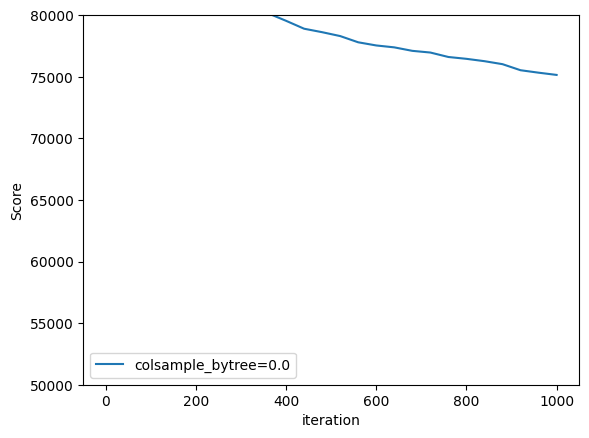

In [32]:
plot_results(df_colsample_bytree, ylim=(50000, 80000))

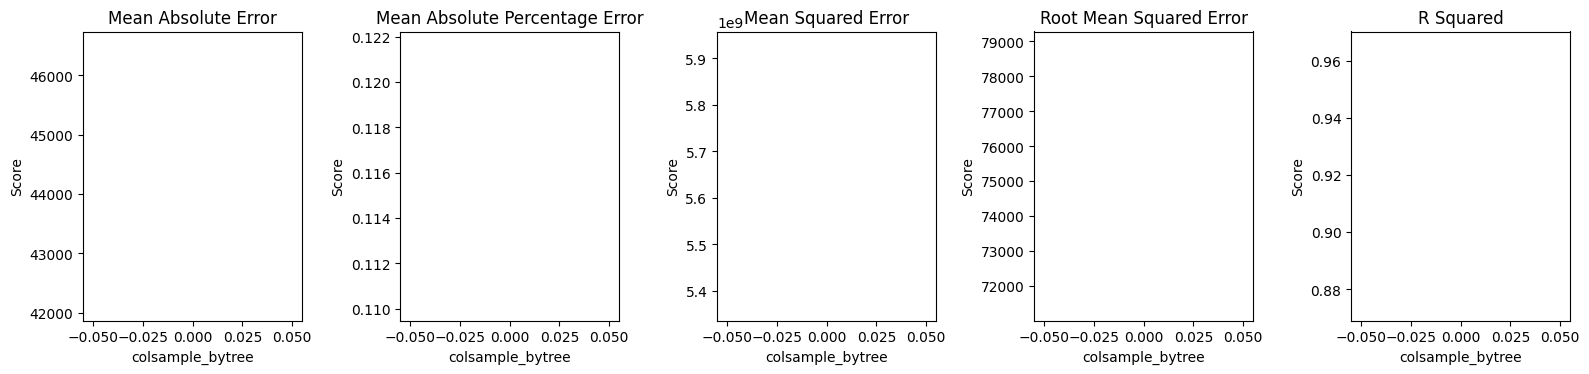

{'Mean Absolute Error': {0.0: 44303.037}, 'Mean Absolute Percentage Error': {0.0: 0.11585}, 'Mean Squared Error': {0.0: 5646967726.194}, 'Root Mean Squared Error': {0.0: 75146.30879952788}, 'R Squared': {0.0: 0.9196}}


In [33]:
plot_evals(evals_colsample_bytree, "colsample_bytree")

### - **Let's train the `colsample_bylevel` hyperparameter**
- Values between 0.1 and 1.0

In [34]:
df_colsample_bylevel = pd.DataFrame()
evals_colsample_bylevel = {}

In [35]:
%%capture output

colsample_bylevel = 0.86

watchlist = [(dm_train, "train"), (dm_val, "val")]
xgb_params = {
    "objective"             : objective,
    "eval_metric"           : eval_metric,
    
    "max_depth"             : best_max_depth,
    "subsample"             : best_subsample,
    "colsample_bytree"      : best_colsample_bytree,
    "colsample_bylevel"     : colsample_bylevel
}

model = xgb.train(xgb_params, dm_train, num_boost_round=1001, evals=watchlist, verbose_eval=40)

In [36]:
temp = parse_output(output.stdout)

df_colsample_bylevel["iteration"] = temp["iteration"]
df_colsample_bylevel[f"colsample_bytree={colsample_bylevel}"] = temp["val_rmse"]

preds = model.predict(dm_val)
evals_colsample_bylevel[colsample_bylevel] = eval(y_val, preds)

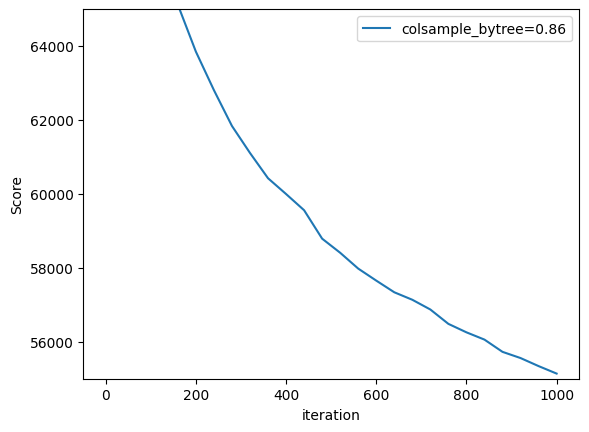

In [37]:
plot_results(df_colsample_bylevel, ylim=(55000, 65000))

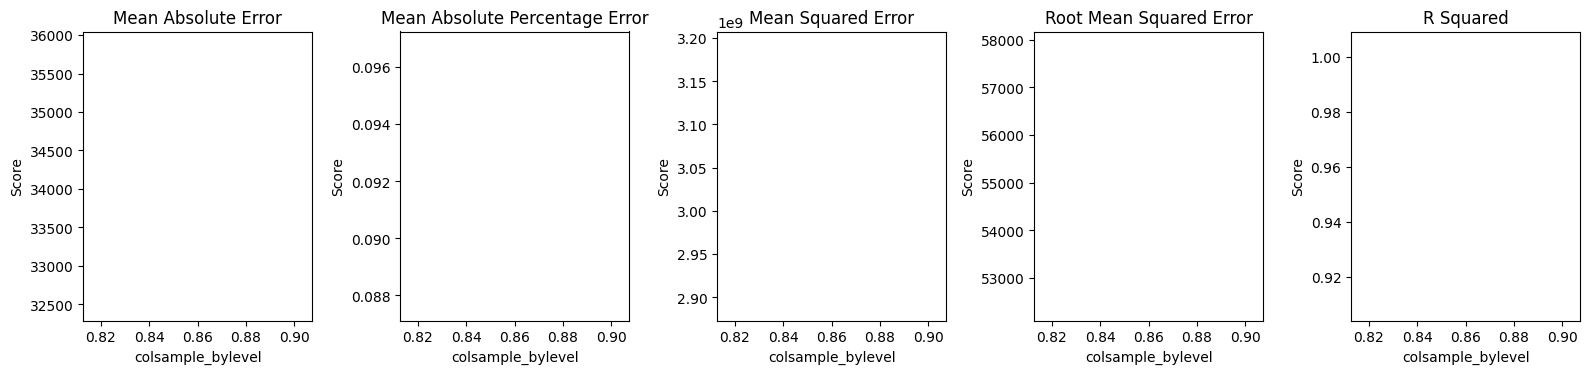

{'Mean Absolute Error': {0.86: 34167.257}, 'Mean Absolute Percentage Error': {0.86: 0.09218}, 'Mean Squared Error': {0.86: 3040332374.677}, 'Root Mean Squared Error': {0.86: 55139.20905015776}, 'R Squared': {0.86: 0.9567}}


In [38]:
plot_evals(evals_colsample_bylevel, "colsample_bylevel")

### - **Let's train the `colsample_bynode` hyperparameter**
- Values between 0.1 and 1.0

In [39]:
df_colsample_bynode = pd.DataFrame()
evals_colsample_bynode = {}

In [40]:
%%capture output

colsample_bynode = 0.6

watchlist = [(dm_train, "train"), (dm_val, "val")]
xgb_params = {
    "objective"             : objective,
    "eval_metric"           : eval_metric,
    
    "max_depth"             : best_max_depth,
    "subsample"             : best_subsample,
    "colsample_bytree"      : best_colsample_bytree,
    "colsample_bylevel"     : best_colsample_bylevel,
    "colsample_bynode"      : colsample_bynode
}

model = xgb.train(xgb_params, dm_train, num_boost_round=1001, evals=watchlist, verbose_eval=40)

In [41]:
temp = parse_output(output.stdout)

df_colsample_bynode["iteration"] = temp["iteration"]
df_colsample_bynode[f"colsample_bytree={colsample_bynode}"] = temp["val_rmse"]

preds = model.predict(dm_val)
evals_colsample_bynode[colsample_bynode] = eval(y_val, preds)

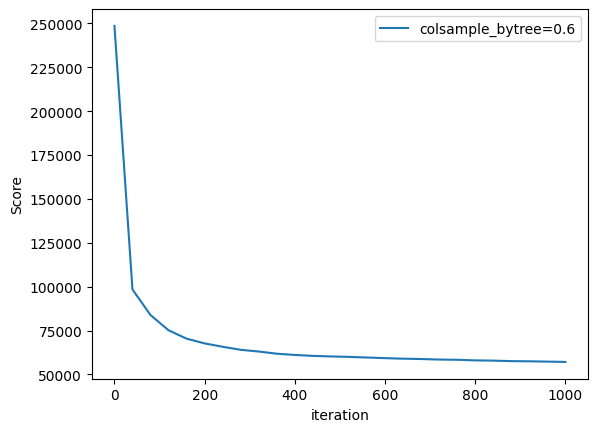

In [42]:
plot_results(df_colsample_bynode)

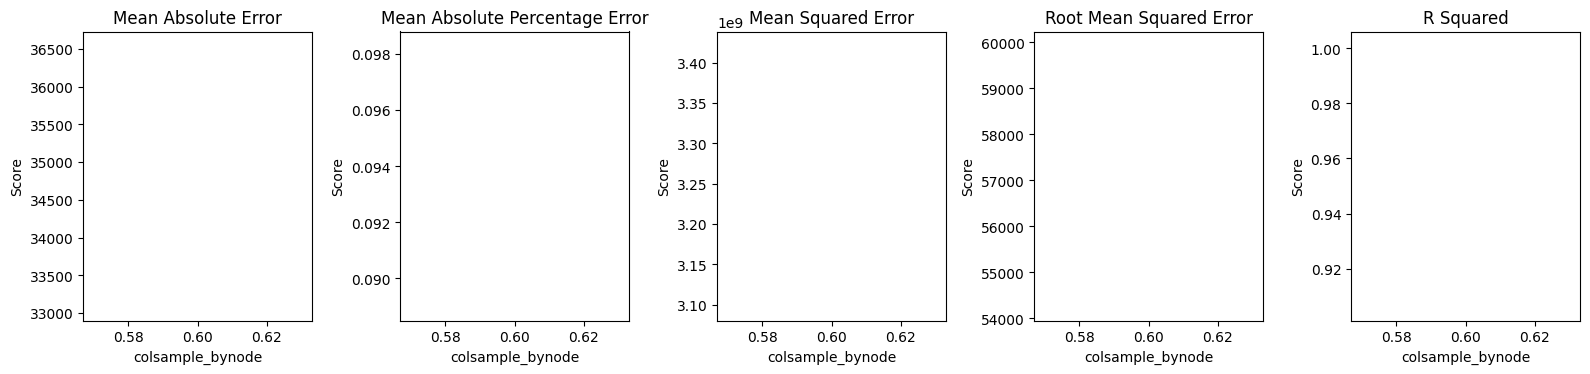

{'Mean Absolute Error': {0.6: 34814.72}, 'Mean Absolute Percentage Error': {0.6: 0.09365}, 'Mean Squared Error': {0.6: 3259461955.129}, 'Root Mean Squared Error': {0.6: 57091.69777760161}, 'R Squared': {0.6: 0.9536}}


In [43]:
plot_evals(evals_colsample_bynode, "colsample_bynode")

### - **Let's train the `min_child_weight` hyperparameter**


In [44]:
df_min_child_weight = pd.DataFrame()
evals_min_child_weight = {}

In [45]:
%%capture output

min_child_weight = 8

watchlist = [(dm_train, "train"), (dm_val, "val")]
xgb_params = {
    "objective"             : objective,
    "eval_metric"           : eval_metric,
    
    "max_depth"             : best_max_depth,
    "subsample"             : best_subsample,
    "colsample_bytree"      : best_colsample_bytree,
    "colsample_bylevel"     : best_colsample_bylevel,
    "colsample_bynode"      : best_colsample_bynode,

    "min_child_weight"      : min_child_weight
}

model = xgb.train(xgb_params, dm_train, num_boost_round=1001, evals=watchlist, verbose_eval=40)

In [46]:
temp = parse_output(output.stdout)

df_min_child_weight["iteration"] = temp["iteration"]
df_min_child_weight[f"min_child_weight={min_child_weight}"] = temp["val_rmse"]

preds = model.predict(dm_val)
evals_min_child_weight[min_child_weight] = eval(y_val, preds)

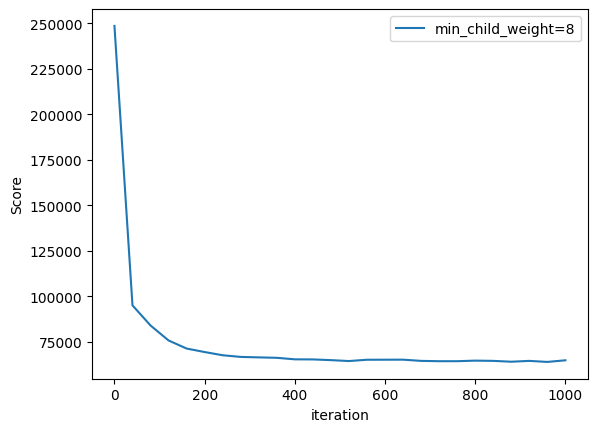

In [47]:
plot_results(df_min_child_weight)

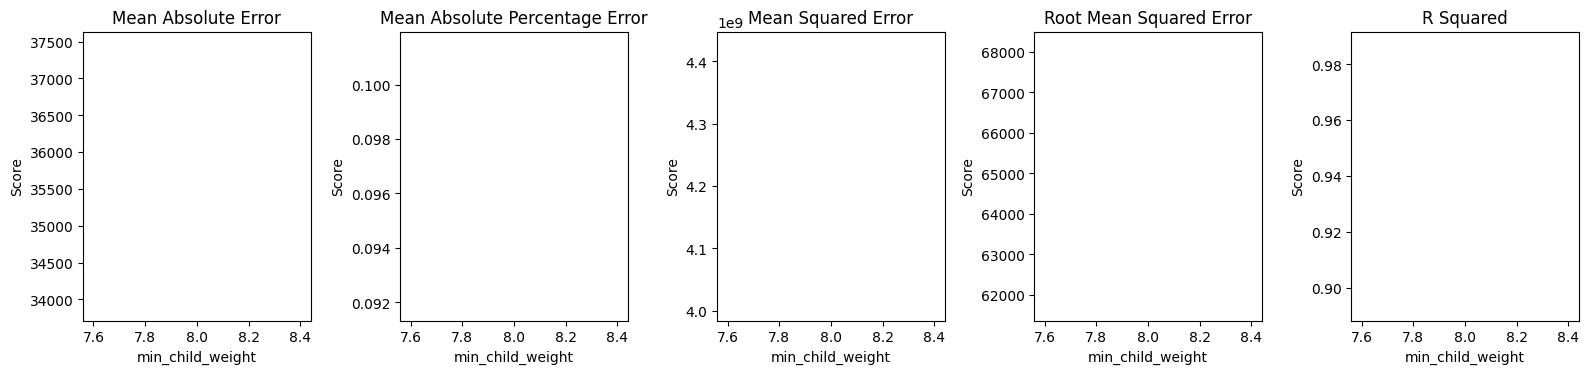

{'Mean Absolute Error': {8: 35675.462}, 'Mean Absolute Percentage Error': {8: 0.09664}, 'Mean Squared Error': {8: 4216124843.781}, 'Root Mean Squared Error': {8: 64931.693677132746}, 'R Squared': {8: 0.94}}


In [48]:
plot_evals(evals_min_child_weight, "min_child_weight")

### - **Let's train the `lambda` hyperparameter**
- Ranging from 0.1 to 1.0, then trying some values larger than 1.0

In [49]:
df_lambda = pd.DataFrame()
evals_lambda = {}

In [50]:
%%capture output

lambda_val = 20

watchlist = [(dm_train, "train"), (dm_val, "val")]

xgb_params = {
    "objective"             : objective,
    "eval_metric"           : eval_metric,
    
    "max_depth"             : best_max_depth,
    "subsample"             : best_subsample,
    "colsample_bytree"      : best_colsample_bytree,
    "colsample_bylevel"     : best_colsample_bylevel,
    "colsample_bynode"      : best_colsample_bynode,
    "min_child_weight"      : best_min_child_weight,

    "lambda"                : lambda_val,
}

model = xgb.train(xgb_params, dm_train, num_boost_round=1001, evals=watchlist, verbose_eval=40)

In [51]:
temp = parse_output(output.stdout)

df_lambda["iteration"] = temp["iteration"]
df_lambda[f"lambda={lambda_val}"] = temp["val_rmse"]

preds = model.predict(dm_val)
evals_lambda[lambda_val] = eval(y_val, preds)

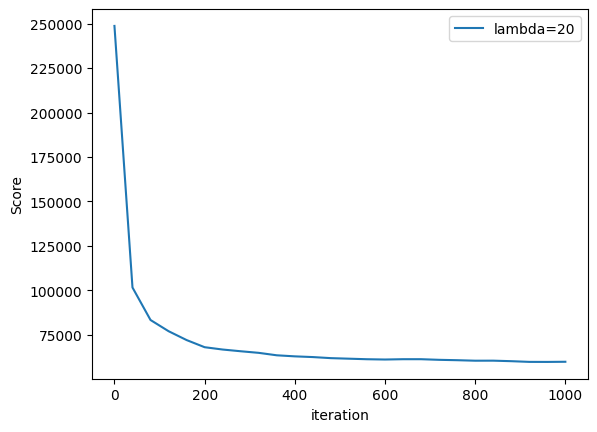

In [52]:
plot_results(df_lambda)

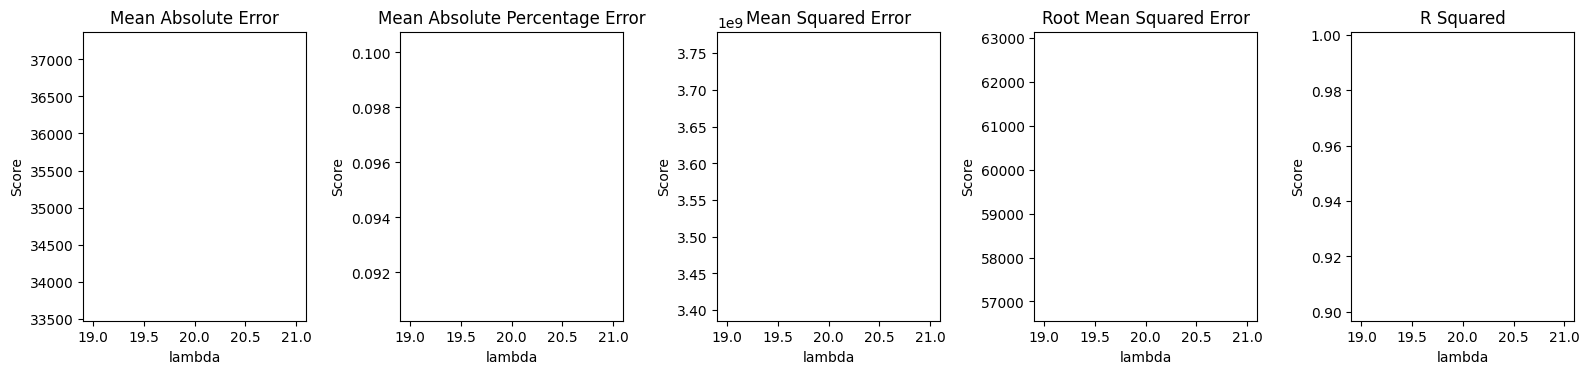

{'Mean Absolute Error': {20: 35425.114}, 'Mean Absolute Percentage Error': {20: 0.0955}, 'Mean Squared Error': {20: 3582465564.14}, 'Root Mean Squared Error': {20: 59853.70134035154}, 'R Squared': {20: 0.949}}


In [53]:
plot_evals(evals_lambda, col_name="lambda")

### - Finally, let's train `eta`
- Smaller learning rates typically give better results but can take a long time

In [54]:
df_eta = pd.DataFrame()
evals_eta = {}

In [55]:
%%capture output

eta = 0.01

watchlist = [(dm_train, "train"), (dm_val, "val")]
xgb_params = {
    "objective"             : objective,
    "eval_metric"           : eval_metric,
    
    "max_depth"             : best_max_depth,
    "subsample"             : best_subsample,
    "colsample_bytree"      : best_colsample_bytree,
    "colsample_bylevel"     : best_colsample_bylevel,
    "colsample_bynode"      : best_colsample_bynode,
    "min_child_weight"      : best_min_child_weight,
    "lambda"                : best_lambda,

    "eta"                   : eta
}

model = xgb.train(xgb_params, dm_train, num_boost_round=5001, evals=watchlist, verbose_eval=100)

In [56]:
temp = parse_output(output.stdout)

df_eta["iteration"] = temp["iteration"]
df_eta[f"eta={eta}"] = temp["val_rmse"]

preds = model.predict(dm_val)
evals_eta[eta] = eval(y_val, preds)

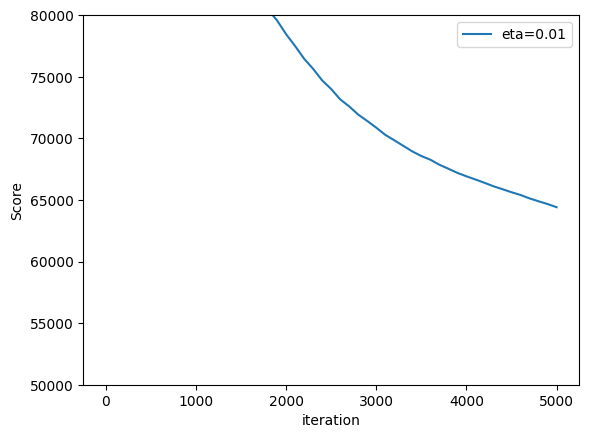

In [57]:
plot_results(df_eta, ylim=(50000, 80000))

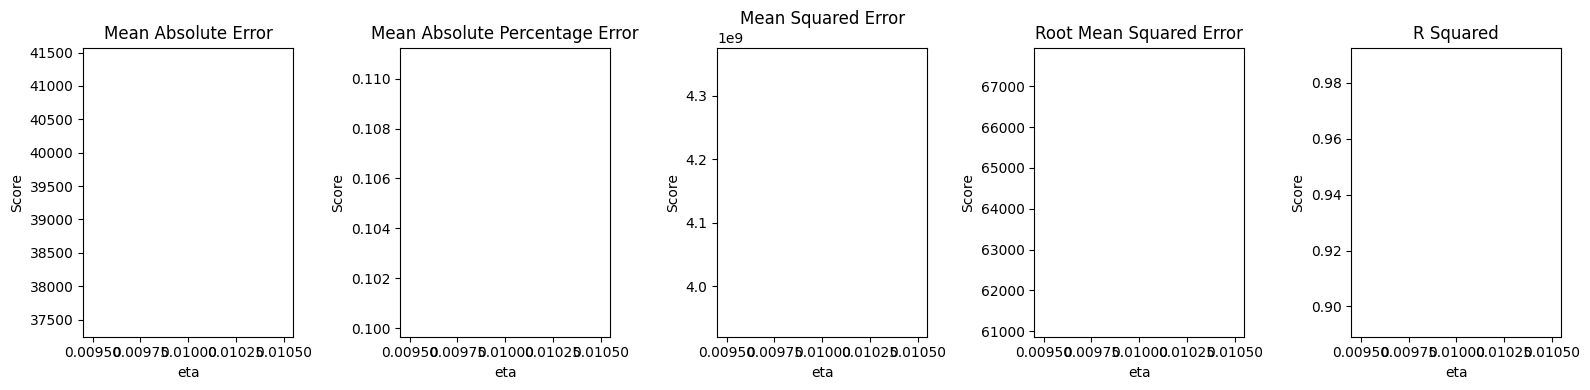

{'Mean Absolute Error': {0.01: 39409.457}, 'Mean Absolute Percentage Error': {0.01: 0.10545}, 'Mean Squared Error': {0.01: 4148358228.705}, 'Root Mean Squared Error': {0.01: 64407.74975657044}, 'R Squared': {0.01: 0.9409}}


In [58]:
plot_evals(evals_eta, "eta")

## - **Training the final model**

In [59]:
%%capture output

watchlist = [(dm_train, "train"), (dm_val, "val")]
xgb_params = {
    "objective"             : objective,
    "eval_metric"           : eval_metric,
    
    "max_depth"             : best_max_depth,
    "subsample"             : best_subsample,
    "colsample_bytree"      : best_colsample_bytree,
    "colsample_bylevel"     : best_colsample_bylevel,
    "colsample_bynode"      : best_colsample_bynode,
    "min_child_weight"      : best_min_child_weight,
    "lambda"                : best_lambda,

    "eta"                   : best_eta
}

model = xgb.train(xgb_params, dm_train, num_boost_round=2001, evals=watchlist, verbose_eval=40)

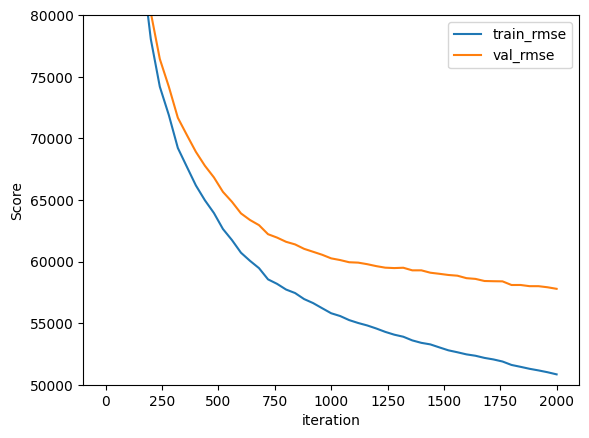

In [60]:
df_results = parse_output(output.stdout)
plot_results(df_results, ylim=(50000, 80000))

In [61]:
preds = model.predict(dm_val)
evals = eval(y_val, preds)
evals

{'Mean Absolute Error': 34757.728,
 'Mean Absolute Percentage Error': 0.09429,
 'Mean Squared Error': 3338934082.714,
 'Root Mean Squared Error': 57783.51047413094,
 'R Squared': 0.9525}

## - **Training the data on the full dataset**

In [62]:
xgb_params = {
    "objective"             : objective,

    "max_depth"             : best_max_depth,
    "subsample"             : best_subsample,
    "colsample_bytree"      : best_colsample_bytree,
    "colsample_bylevel"     : best_colsample_bylevel,
    "colsample_bynode"      : best_colsample_bynode,
    "min_child_weight"      : best_min_child_weight,
    "lambda"                : best_lambda,
    "eta"                   : best_eta
}

model = xgb.train(xgb_params, dm_full_train, num_boost_round=2001)

In [63]:
preds = model.predict(dm_test)

evals = eval(y_test, preds)
evals, base_performance

({'Mean Absolute Error': 34791.803,
  'Mean Absolute Percentage Error': 0.09397,
  'Mean Squared Error': 3343678987.655,
  'Root Mean Squared Error': 57824.553501561946,
  'R Squared': 0.9522},
 {'Mean Absolute Error': 33107.9,
  'Mean Absolute Percentage Error': 0.09033,
  'Mean Squared Error': 3260673319.442,
  'Root Mean Squared Error': 57102.30572789509,
  'R Squared': 0.9536})

- The model performs slightly better when we include the full training dataset. This is a good sign.
- Validation on the test dataset has passed. Let's use the entire dataset to train the model

## Creating a "Random" Model
- Generate some random numbers to see how our model performs against random guessing.

In [64]:
RDG = np.random.default_rng()

random_nums = []
for _ in range(len(y_test)):
    random_nums.append(RDG.random() * 2000000)

In [65]:
eval(y_test, random_nums)

{'Mean Absolute Error': 701464.961,
 'Mean Absolute Percentage Error': 2.65355,
 'Mean Squared Error': 738078106567.111,
 'Root Mean Squared Error': 859114.7225877991,
 'R Squared': -9.5487}